# Parameter inference in models of decision making

Welcome to week 3 of module 1! 

As discussed in the lecture, a central challenge in mechanistic modeling is to identify parameters that are in agreement with model and data using Bayesian inference. This is especially challenging in mechanistic models, since the likelihood function is commonly intractable. 

After working with a complex mechanistic model for the last two weeks, this week we will turn to simpler mechanistic model already discussed in the lecture - the drift diffusion model. We chose this simple mechanistic model because it is very fast in generating data (especially compared to the Wong & Wang model from last week). This will enable you to try out different methods for Bayesian parameter inference yourself: A classical approach called rejection ABC and a more modern one, which is based on density estimation.

## A simple mechanistic model of decision making: The Drift diffusion model (DDM)

We will use the DDM as a simple example:

The DDM simulates a perceptual decision making process in a [two alternative forced choice experiment (2AFC)](https://en.wikipedia.org/wiki/Two-alternative_forced_choice) with a single scalar variable $x$. For example, the the task for the subject could be to report the direction of movement of a cloud of points in which a certain amount of points move left or right. 

You can think of $x$ as the sensory evidence towards one or the other choice: it starts at a neutral position, e.g., at zero, and moves up or down following a mean drift $\mu$ (the first parameter of the model) plus some noise (external and internal noise) $\sigma$ (the second parameter of the model) and a decision towards one or the other side is made when a pre-defined decision boundary is hit.

In a way it is performing a random walk with a drift towards one or the other choice ([more details](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)), that is why it is called drift ($\mu$) and diffusion ($\sigma$) model. There are more reasons for this name, the interested reader is referred to [here](https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation).

Formally, the drift diffusion model is defined through the following equation: 
$$ 
\begin{align}
\text{d}X = \mu \text{dt} + \sigma \text{dW}
\end{align}
$$
where $X$ is the decision variable, $\mu$ the drift, and $\sigma$ the diffusion parameter (effectively scaling the variance of the noise coming from the [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) W). This equation is a stochastic differential equation (SDE) with no closed-form solution. Therefore, we must use a SDE solver to generate data: given a drift $\mu$ and a diffusion parameter $\sigma$ we integrate the equation for a given number of time steps and obtain the trace of $X$. Then the reaction time is given by the time when $X$ crossed the predefined decision boundary and the decision is given by the sign of the $X$ at that time. 

- You can find a short introduction to the DDM model in the Neural Dynamics book (16.4.2): https://neuronaldynamics.epfl.ch/online/Ch16.S4.html Note that they use a slightly different notation. 
- There are three additional packages you need to install in your conda environment for this exercise: 
  - To simulate the DDM, please install `sdeint`, e.g., with `pip install sdeint`
  - For neural network training, install pytorch, following [this guide](https://pytorch.org/get-started/) and selecting your platform, `Conda`, and `None` for the `CUDA` option. We also recommend getting familiar with the syntax of PyTorch, which is very close to NumPy, e.g., by following this tutorial: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
  - [tqdm](https://github.com/tqdm/tqdm) for progress bars: `conda install tqdm`

## Exercise 1: Understanding the model

To complete the exercises in this notebook we provide you with several function needed to generate data with the DDM. It is important that you understand what is going on in all of these functions.

**Overall goal**: Understand the code, how the model generates data and how summary statistics are calculated. 

**Hint**: The functions all depend on each other. It can be helpful to execute each function with the inputs generated from other function in order to understand what they are doing. Have a look at exercises 1 b) and c) for an example.

a) Read the code carefully and write [docstrings](https://www.datacamp.com/community/tutorials/docstrings-python)  and additional explanatory inline comments for all the functions. You can use any format for the docstring you like, [here is a style suggestion](https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html). The docstrings should document what goes into each function and what is returned.

In [1]:
# Make sure to install the required packages so that all imports are available.
import numpy as np
import sdeint
import matplotlib.pyplot as plt
%matplotlib inline
import torch
torch.set_default_tensor_type(torch.FloatTensor)  # Calculate on CPU rather than GPU per default
import tqdm

#### Functions for the DDM

To run inference with the model, we need two functions, prior (the prior over parameters) and simulator (the model): 

In [2]:
from typing import Callable, Union, Tuple

def prior(num_samples: int=1) -> torch.Tensor:
    """Returns samples from a uniform prior in [-2.0, 2.0]."""
    # Expand by [1] to let the prior return 2D tensors (1st D is the batch dim).
    dist = torch.distributions.Uniform(low=-2.0, high=2.0).expand([1])
    return dist.sample((num_samples,))


def simulator(parameters: Union[float, torch.Tensor],
              num_trials: int=100, 
              sigma: float=0.5, 
              T: float=5.0, 
              y0: float=0, 
              a: float=1.0, 
              return_traces: bool=False, 
              nbins: int=20, 
              dt: float=0.01) -> Tuple[torch.Tensor, torch.Tensor]:
    """Simulate the DMM and return summary statistics (and traces).
    
    Summary statistics are currenlty defined as the histogram of reaction
    times, where the bin reach from -T to T, and negative bins encode the
    traces crossing -a and positive bins encode the traces crossing +a.
    
    Args: 
        parameters: parameters for the DDM, here just the drift mu. 
            If multiple mu are passed, they are simulated sequentially.
        num_trials: Number of trials simulated for a single mu. Summary
            statistics are calculated across trials.
        sigma: Noise / diffusion parameter of the DDM.
        T: Time simulated [sec]. 
        y0: Initial condition / starting point of the DDM simulation.
        a: Decision boundary for the DDM simulation.
        return_traces: Whether to return the simulated DDM traces in
            addition to the summary stats.
        nbins: Number of bin in the summary statistics histogram.
        dt: Step size of the SDE integration.
        
    Returns:
        x_traces: num_trial traces for each parameter mu.
        stats: counts of a RT historgram reaching from -T to T.
    """
    
    # Input normalization: we want parameters to have shape [batch_size, mu_shape]
    # E.g., [1, 1] for a single mu, or [10, 1] for ten mus.
    if type(parameters) == float:
        parameters = torch.tensor([parameters])
    if parameters.ndim == 1:
        parameters = parameters.reshape(1, -1)
        
    # number of parameters to simulate
    num_parameters = parameters.shape[0]
    
    x_traces = []
    stats = []

    # run simulation one by one as this is faster than batching in sdeint.
    for idx_param in range(num_parameters): 
        
        num_simulations = num_trials
        mu = parameters[idx_param].numpy()

        # Expand mu for each trial, to simulate all trials at once in sdeint.
        mu_expanded = np.repeat(mu, num_trials)

        # Define time steps to be simulated.
        tspan = np.linspace(0.0, T, int(T/dt))
        # Expand initial conditions across trials.
        y0_expanded = y0 * np.ones(num_simulations)

        # Define f and G as required by sdeint, using expanded parameters.
        # See documentation on sdeint for more details: https://pypi.org/project/sdeint/
        def f(x, t):
            return np.eye(num_simulations).dot(mu_expanded)

        def G(x,t):
            return sigma * np.eye(num_simulations)
    
        x_traces_param = sdeint.itoEuler(f, G, y0_expanded, tspan).T

        rts, decisions = find_rts_and_decisions(x_traces_param, 1, num_trials, tspan, a=a)
        stats_param = calculate_histogram_stats(rts, decisions, T=T, nbins=nbins)
        
        # collect result as torch tensors (to be able to use PyTorch Neural Nets later on)
        x_traces.append(torch.as_tensor(x_traces_param, dtype=torch.float32))
        stats.append(torch.as_tensor(stats_param, dtype=torch.float32))
    
    # Concatenate all tensors in a list to one tensor.
    x_traces = torch.cat(x_traces)
    stats =  torch.cat(stats)
    
    if return_traces: 
        return x_traces, stats
    else:
        return stats


def find_rts_and_decisions(x_traces: np.ndarray, 
                           num_parameters: int, 
                           num_trials: int, 
                           tspan: np.ndarray, 
                           a: float=1.0) -> Tuple[np.ndarray, np.ndarray]:
    """Return reaction times and decisions directions given DDM traces.
    
    For traces that did not cross the threshold before T, the RT is set to T
    and the decision is set to 1 if x>0 and to -1 if x <= 0.
    
    Args:
        x_traces: Decision traces simulated from the DDM.
        num_parameters: Number of simulated parameters.
        num_trials: Number of trials per parameter.
        tspan: Array of simulated time steps.
        a: Decision threshold.
    """
    
    # Check number of traces.
    assert x_traces.shape[0] == num_parameters * num_trials
    
    rts = []
    decisions = []
    
    for param_idx in range(num_parameters):
        
        # get traces for this param.
        x_traces_param = x_traces[param_idx * num_trials: (param_idx + 1)*num_trials, ]
            
        # find crossing of decision threshold
        rows, _ = ((abs(x_traces_param) >= a)).nonzero()
        # the unique rows are the ones with decisions. 
        unique_rows = np.unique(rows)
        
        # find undecisive trials
        undecided_idx = [i for i in range(num_trials) if i not in unique_rows]
        # enforce decision in last time bin. 
        x_traces_param[undecided_idx, -1] = a * np.sign(x_traces_param[undecided_idx, -1])
        
        # now search again for decision threshold, all trials are decisive now.
        rows, cols = ((abs(x_traces_param) >= a)).nonzero()
        # get first indices for every trial
        unique_rows, trial_idx = np.unique(rows, return_index=True)
        
        # get first decision time bin idx for every trial
        decision_idx = cols[trial_idx]
        
        # find proportion of up decisions by looking at sign at decision idx.
        decisions_param = np.sign(x_traces_param[unique_rows, decision_idx])
        rt_param = tspan[decision_idx]

        # mark the direction of the decision by the multiplying the rt with the sign.
        rts.append(rt_param)
        decisions.append(decisions_param)
        
    return np.array(rts), np.array(decisions)


def calculate_histogram_stats(rts: np.ndarray, 
                              decisions: np.ndarray, 
                              T: float, 
                              nbins: int=20) -> np.ndarray:
    """Return histogram bin counts given reaction times and decisions.
    
    Both, RTs and decisions are encoded in the counts by expanding the
    the histogram from -T to T and by setting RTs with a negative (-a)
    decision to -RT.
    
    Args: 
        rts: Array of reaction times.
        decisions: Array of decisions (-1, 1), one for each rt.
        T: Time simulated.
        nbins: Number of bins for the histogram.
    """

    # mark rts with decision direction sign
    sign_rts = rts * decisions

    # fixed bins
    bins = np.linspace(-T, T, nbins)

    counts = []
    for trial_idx in range(sign_rts.shape[0]): 
        # count for every trial
        trial_count, *_ = np.histogram(sign_rts[trial_idx, :], bins=bins)
        counts.append(trial_count)
    
    return np.array(counts)

## Exercise 1 continued:

Look at the two cells below. What is happening here? 

b) Describe what is happening in the first cell below.

The simulator is called with two parameters, `mu=-0.3` and `mu=0.3`. For each parameter 50 trials are simulated for 5 seconds with a time step of 0.01 seconds. By setting `return_traces=True` the decision traces are returned.

c) Describe the figure in the second cell below. Change the title and labels of the figure accordingly.

This figure plots the decision traces generated above. The traces coming from `mu=0.3` are plotted in orange, and those for `mu=-0.3` are plotted in blue.

In [3]:
num_trials, T, dt = 50, 5, 0.01
x_traces, _ = simulator(torch.tensor([[-0.3], [0.3]]), num_trials=num_trials, T=T, dt=dt, return_traces=True)

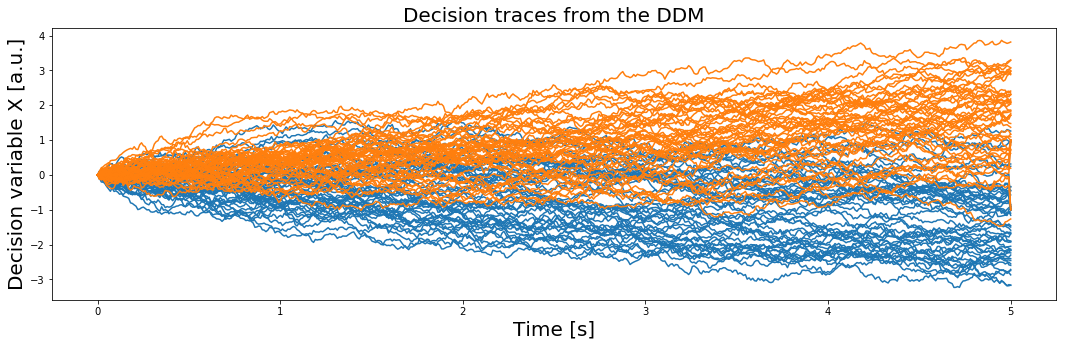

In [4]:
plt.figure(figsize=[18, 5])
tspan = np.linspace(0, T, int(T/dt))

plt.plot(tspan, x_traces[:num_trials, :].numpy().T, c="C0")
plt.plot(tspan, x_traces[num_trials:, :].numpy().T, c="C1")
plt.title("Decision traces from the DDM", fontsize=20)
plt.ylabel('Decision variable X [a.u.]', fontsize=20)
plt.xlabel('Time [s]', fontsize=20);

c) We defined two functions, `prior` and `simulator`. The prior returns draws from a uniform prior in [-2.0, +2.0] over parameters. Look at the three lines of code in the cell below. What is happening here? What does the output of the simulator represent?

We sample from the prior a single mu and call the simulator to get the summary statistics of the traces. We then print the parameter and the summary statistics. The statistics are the counts of a histrogram reaching from -T to T, where negative time bins count negative decisions, and positive time bin encode positive decisions. 

There are high counts slighty left from the middle of the histrogram because the high negative mu-parameter we drew from the prior resulted in many traces hitting the negative decision bound `-a` with short RTs.

In [5]:
param = prior(1)
stats = simulator(param)
param, stats

(tensor([[-0.8707]]),
 tensor([[ 0.,  0.,  1.,  2.,  1.,  8., 16., 37., 35.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.]]))

## Exercise 2: Parameter inference with rejection ABC

In the lecture and the tutorial you learned about rejection ABC, the root of all simulation-based inference algorithms (more details in the lecture slides or [here](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation#The_ABC_rejection_algorithm). Here, you will implement this algorithm and use it do inference over the drift parameter $\mu$ of the DDM, given observed data $s_o$. 

**Overall goal**: Obtain 100 samples from the approximate posterior using rejection ABC.

a) Write a function called `rejection_abc` with the function signature as in the cell below. The function takes as arguments a prior, simulator, observed_data, a simulation budget, a distance function and a quantile. The quantile is used to select the parameters according to the top quantile of the sorted distances. We provide the arguments and the return of the function, and the distance function. Make sure to write docstrings and comments in your function. (**Hint**: you do not need loops to implement this algorithm, you can pass all parameters at once to the simulator, or to the distance function.)

b) Test your function with small simulation budgets to save time. Later, for the final inference, we suggest a budget of around 10000 simulations (this can take a couple of minutes to run). 

c) Run inference using the observed data and obtain 100 samples from the posterior (quantile=0.01 for a budget of 10000 samples). 

d) Make a pretty figure with title, axis labels and good fontsizes etc showing the histogram of accepted posterior samples. Plot the ground truth parameter $\mu_o$ as vertical line. Are the posterior samples close to the ground truth? 

### The observed data: 

In [6]:
s_o = torch.tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13., 22., 20., 14.,
         11.,  7.,  4.,  4.,  4.]])
mu_o = torch.tensor([[0.4588]])

**Exercise:** Write a function `abc_rejection` that takes as input `prior`, `simulator`, `observation` and `epsilon` (or `quantile` for quantile-based rejection) and returns samples from the approximate posterior. Then plot a histogram of posterior samples.

In [8]:
def l2_distance(observation, simulated_data):
    return torch.norm((observation - simulated_data), dim=-1)

def rejection_abc(prior: Callable, 
                  simulator: Callable,
                  observed_data: torch.Tensor,
                  num_simulations: int,
                  distance_fun: Callable,
                  q: float) -> torch.Tensor:
    """
    Return samples from the approximate posterior obtained via rejection ABC
    using a predefined simulation budget.
    
    Here, we perform quantile based rejection ABC, returning the parameters 
    corresponding to the simulated x with top q quantile distances to x_o.
    
    Args: 
        prior: Prior over parameters
        simulator: Simulator returning summary statistics given parameters.
        observed_data: observed data x_o.
        distance_fun: distance function between simulated and observed data.
        q: quantile.
        
    Returns: 
        parameters from the approximate posterior.
    """
    
    # Get parameters from the prior. 
    parameter_candidates = prior(num_simulations)
    # Get corresponding data by simulating
    data = simulator(parameter_candidates)
    
    # Calculate distances to observed data. 
    distances = distance_fun(observed_data, data)
    
    assert q <= 1.0
    # Sort the distances. 
    sortidx = torch.argsort(distances)
    # Get the number of return samples for given q.
    num_top_samples = int(num_simulations * q)
    # Return the samples the correspond to the smallest distances.
    return parameter_candidates[sortidx][:num_top_samples]

In [9]:
samples = rejection_abc(prior, 
                        simulator=simulator, 
                        observed_data=s_o,
                        num_simulations=10000, 
                        distance_fun=l2_distance, 
                        q=.01)

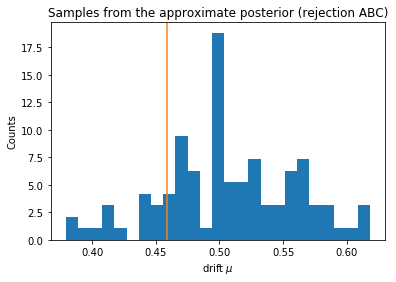

In [11]:
plt.hist(samples.numpy(), 25, density=True);
plt.axvline(mu_o, color="C1")
plt.xlabel(r"drift $\mu$")
plt.ylabel("Counts")
plt.title("Samples from the approximate posterior (rejection ABC)");

## Exercise 3: Parameter inference with Conditional Density Estimation

Rejection ABC, as the name says, is based on rejecting samples, which can be very inefficient if the data is high dimensional. Alternative methods using neural networks for density estimation have been developed in recent years, starting with: https://papers.nips.cc/paper/6084-fast-free-inference-of-simulation-models-with-bayesian-conditional-density-estimation

Here, we coded up a simple version of this approach: A neural network that takes the simulated data as input and regresses this input on the mean and std (in log-space) of a Normal distribution. The Normal distribution is then used to approximate the posterior distribution. 

After training, any observed data point can be passed to the neural network (now a conditional density estimator) and the it will return the parameters for the Normal distribution - for the corresponding posterior. Thus, by giving $s_o$ to the network one can obtain the posterior $p(\mu | s_o)$. 


**Your exercises**: 

a) Read the code carefully to understand what is happening. Consider revisiting a [tutorial on Pytorch](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

b) Use the `tqdm` package to update the code such that it shows progress bars of the training epochs.

c) Pass the observed data `s_o` from above into the network and use the resulting parameters to instantiate a Normal distribution. Plot the probabilities across the support of the prior (-2. to 2.).

d) Draw samples from the posterior and plot them in a histogram. Compare the histogram to the one you obtained by Rejection ABC. Do they differ? If so, what might be reasons for the difference? 

As always, make sure to add title and labels to your figures.

Below is some PyTorch code training a conditional density estimator for inference:

In [12]:
# Create a TensorDataset which we will use for training the density estimator
# From a TensorDataset, we construct a DataLoader that allows splitting data into shuffled batches
# during training of the NN. For background see PyTorch tutorials on data handling
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

parameters = prior(num_samples=10000)
data = simulator(parameters)

train_data = TensorDataset(parameters, data)
data_loader = DataLoader(train_data, batch_size=10, shuffle=True)

Next, we build a conditional density estimation neural network, which regresses on the mean and std (in log-space) of a Normal distribution: 

In [13]:
num_hiddens = [50, 50]
input_size = data.shape[1] 

# The NN takes data (observation) as input
# There are 2 hidden layers of 50 units each
# The regression is onto 2 numbers that will represent the parameters of a Normal distribution
network = nn.Sequential(
    nn.Linear(input_size, num_hiddens[0]),
    nn.ReLU(),
    nn.Linear(num_hiddens[0], num_hiddens[1]),
    nn.ReLU(),
    nn.Linear(num_hiddens[1], 2),
    )

# Create an optimizer
optim = torch.optim.Adam(network.parameters(), lr=0.01)

In [ ]:
# tqdm for progress bars
from tqdm import tqdm

# Train the parameters of the NN in minibatches
losses = []
for epoch in tqdm(range(100)):
    for inputs, outputs in data_loader:
        nn_out = network(outputs)
        cond_dist = torch.distributions.Normal(loc=nn_out[:,0], scale=torch.exp(nn_out[:,1]))
        loss = -1. * cond_dist.log_prob(inputs.reshape(-1)).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())

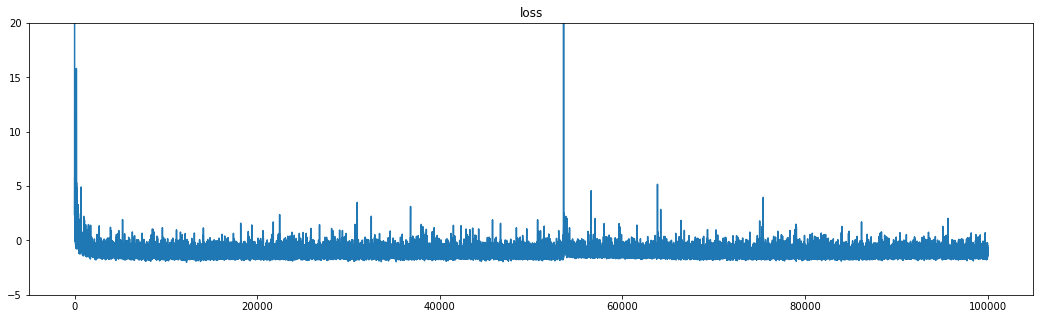

In [18]:
# Plot loss of NN training
plt.figure(figsize=(18, 5))
plt.title('loss')
plt.ylim([-5, 20])
plt.plot(losses);

c) 

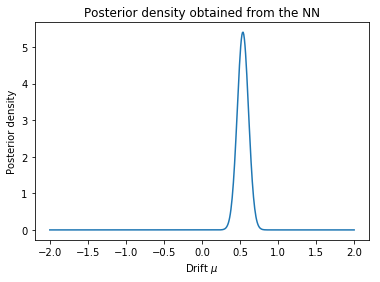

In [15]:
# Your code for exercise 3c:
linspace = torch.linspace(-2.,2., 500).reshape(-1,1)

# Pass the observed data to the network to predict p(theta | x_o).
nn_out = network.forward(s_o)
# Take the nn output to build a Normal distribution.
cond_dist = torch.distributions.Normal(loc=nn_out[:,0], scale=torch.exp(nn_out[:,1]))

plt.plot(linspace, torch.exp(cond_dist.log_prob(linspace).detach()).numpy())
plt.xlabel(r"Drift $\mu$")
plt.ylabel("Posterior density")
plt.title("Posterior density obtained from the NN");

d)

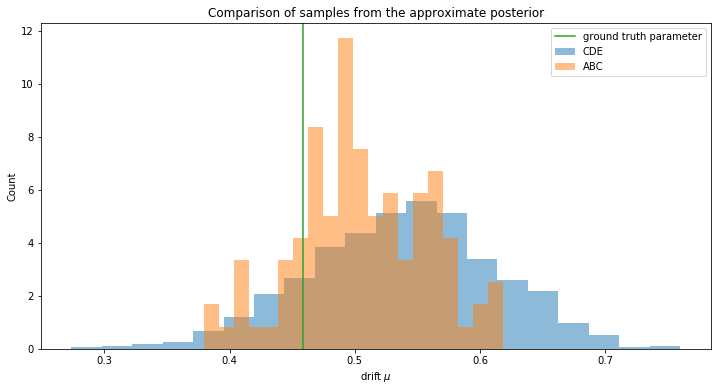

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

plt.hist(cond_dist.sample((1000,)).numpy(), 20, density=True, alpha=0.5, label="CDE")
plt.hist(samples.numpy(), 20, density=True, alpha=0.5, label="ABC");
plt.axvline(mu_o, color="C2", label="ground truth parameter")
plt.xlabel(r"drift $\mu$")
plt.ylabel("Count")
plt.legend()
plt.title("Comparison of samples from the approximate posterior");

## Exercise 4 (Optional) 

If you are interested in trying out more advanced CDE methods, we invite you to have a look at a toolbox we are currently developing in the mackelab, a toolbox for simulation-based inference, called `SBI`: https://github.com/mackelab/sbi 

This exercise is optional. You can have a look at the documentation page at https://www.mackelab.org/sbi/. If you want to proceed, you can clone the repository, follow the installation instructions and try to use the simulator and prior above to run inference on the DDM using `SBI`. 